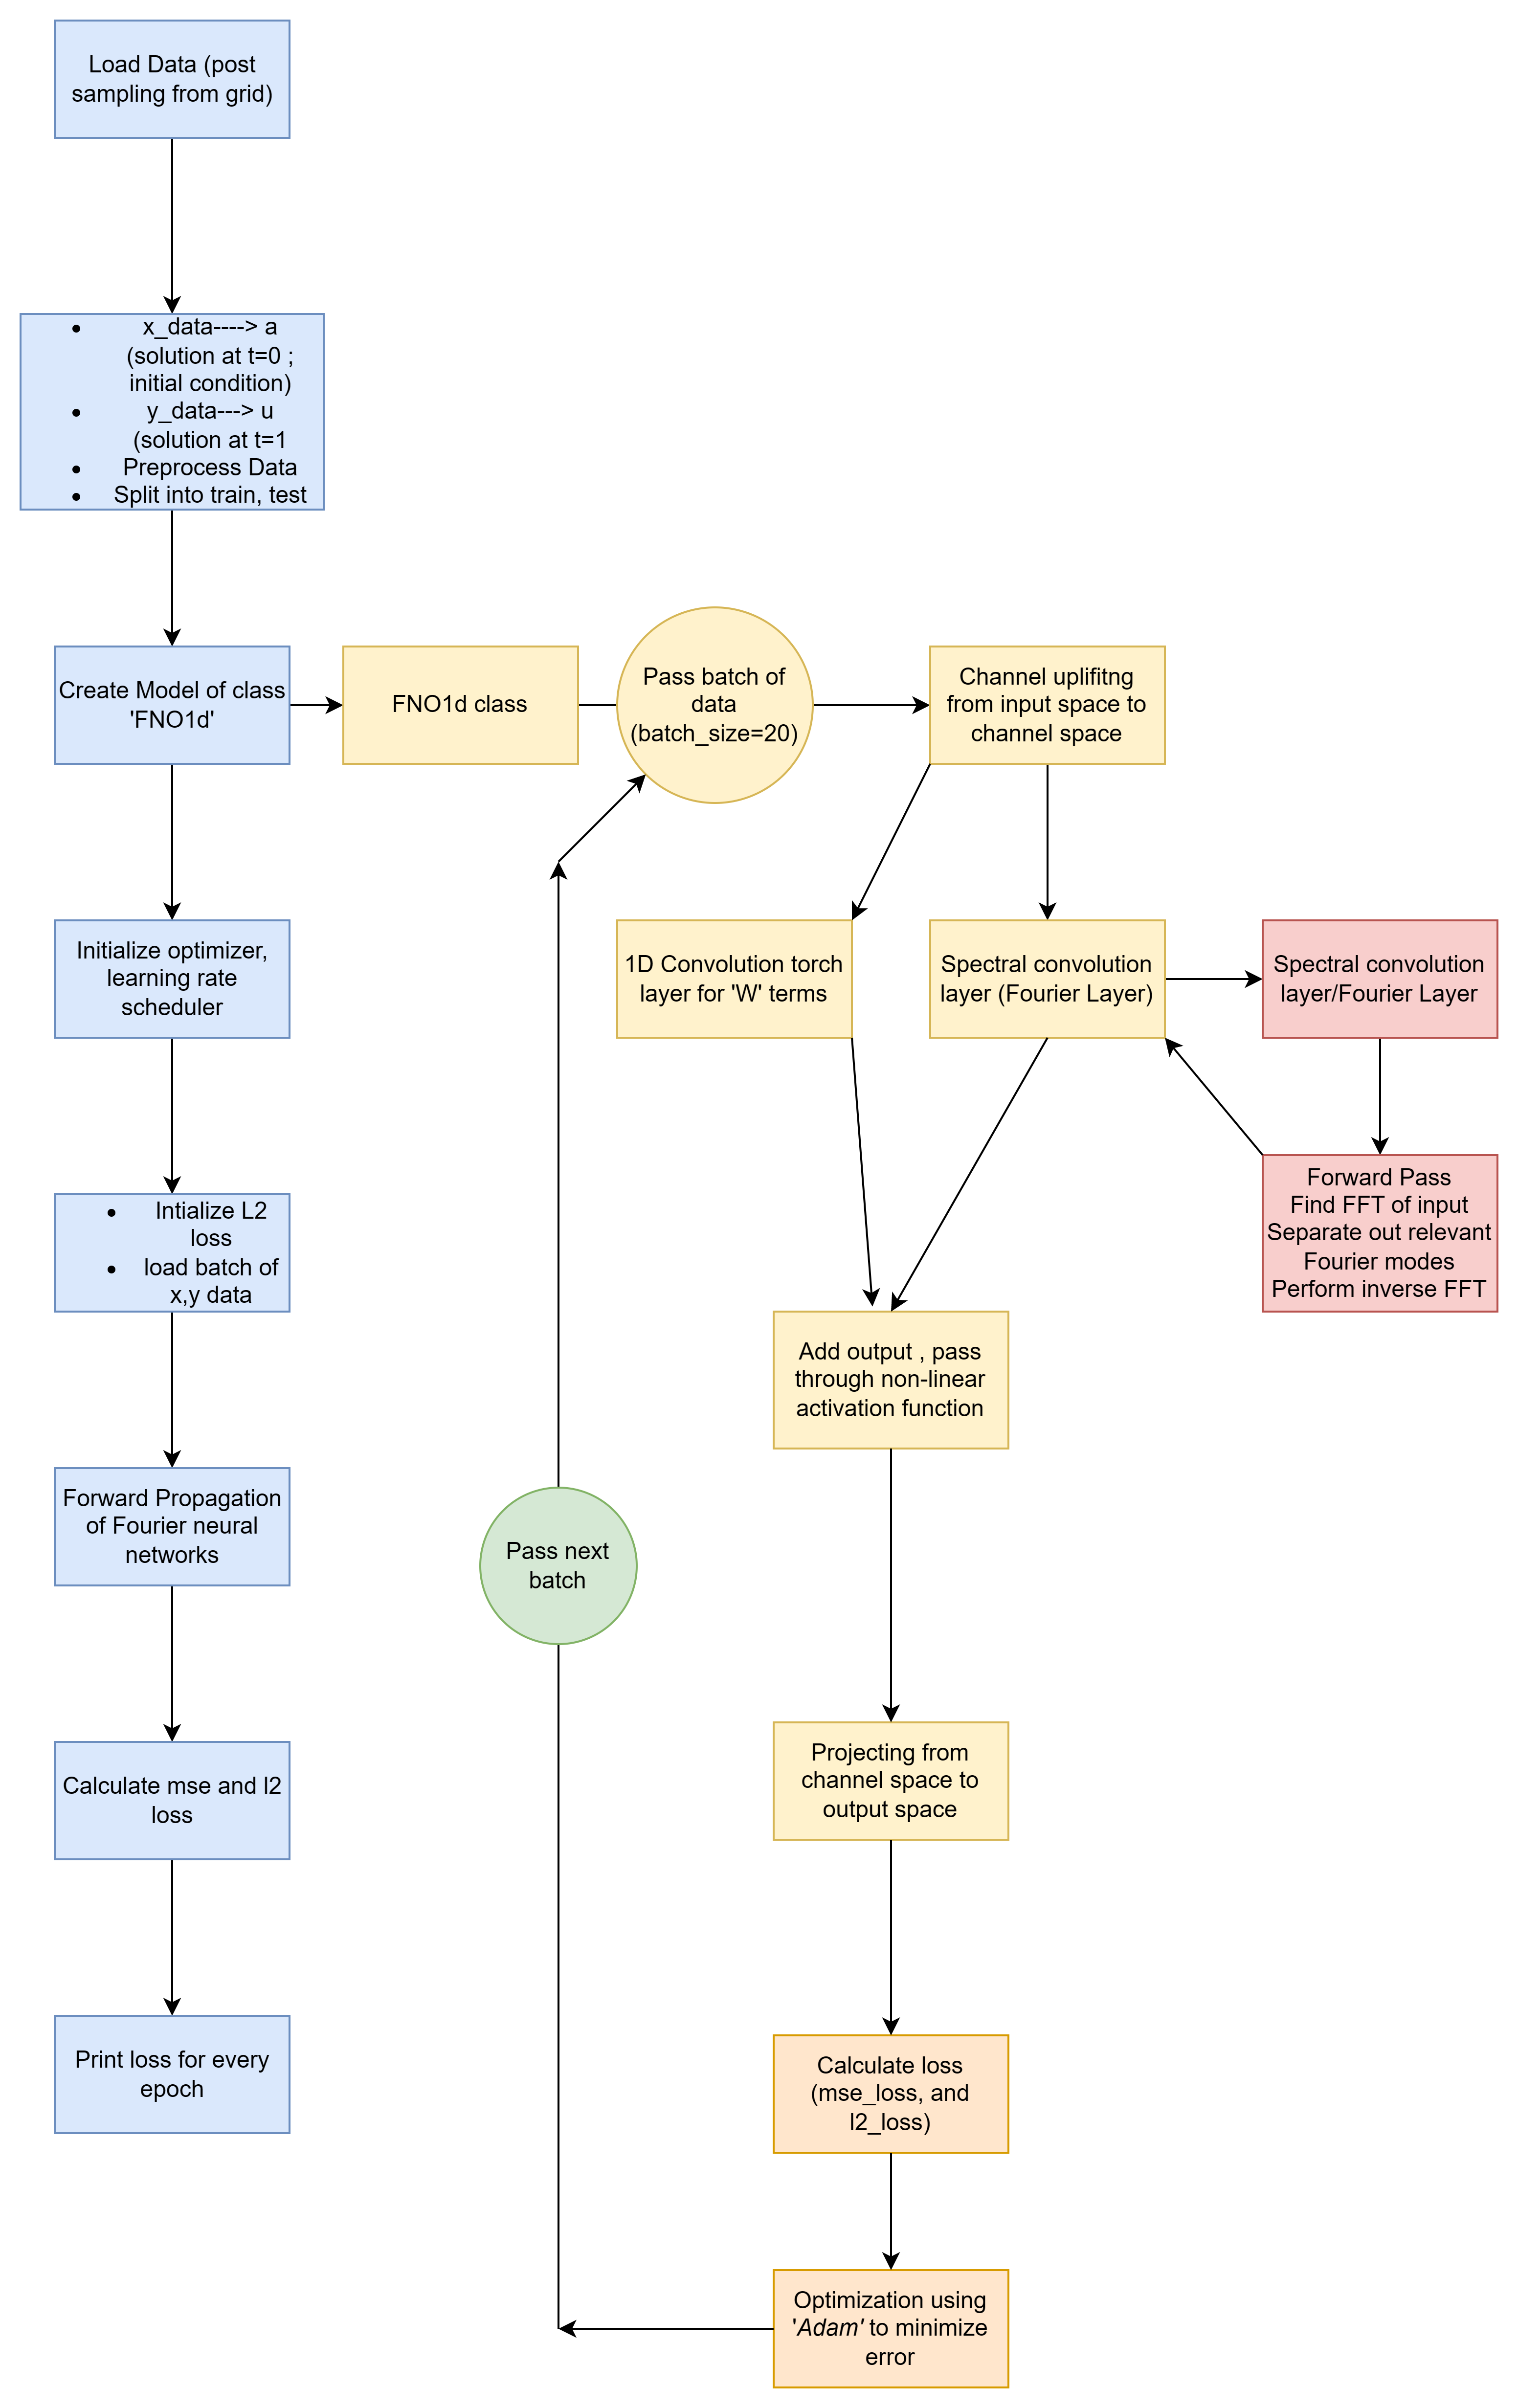

In [3]:
"""

This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import scipy
import operator
from functools import reduce
from functools import partial
from timeit import default_timer


import matplotlib.pyplot as plt


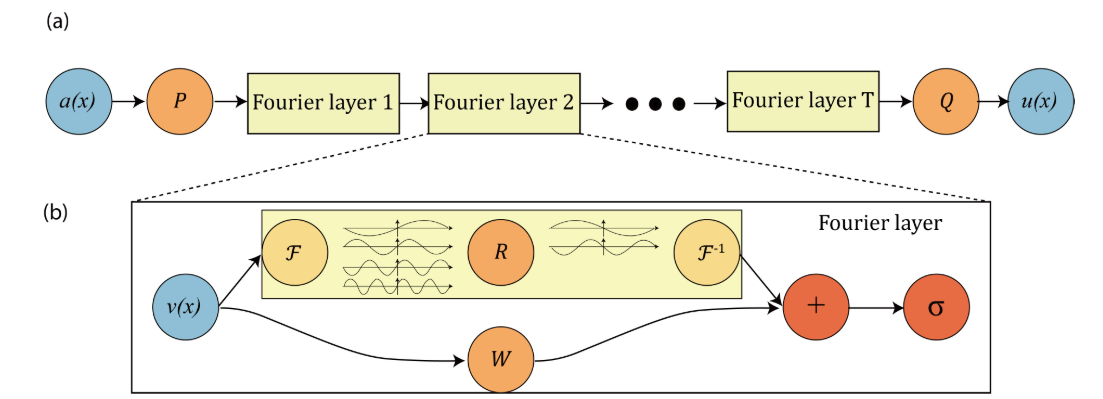

In [4]:
################################################################
#  1d fourier layer
################################################################

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))
        #use the scaling factor to initialise complex weights of dimensions [in_channels, out_channels, modes]

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        #do a complex multiplication of the form written above with truncated fourier modes and weights to do linear transformation 'R'
        #HINT : use 'torch.einsum'
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        #HINT : you can use a torch function to do a fft of a real valued input 'x' so that output contains only positive frequencies
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)#call compl_mul1d function to enable linear transformation of selected modes and complex weights initiated above
        #print(out_ft)

        #Return to physical space
        x =  torch.fft.irfft(out_ft, n=x.size(-1)) #do an inverse fft of out_ft to shift from fourier space to real space using torch function
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.fc0 =  nn.Linear(2, self.width) # input channel is 2: (a(x), x); uplift from 2 features to 64 features using torch linear neural network

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)                            #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv1 =  SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv2 =  SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.conv3 =  SpectralConv1d(self.width, self.width, self.modes1)                           #call SpectralConv1d function with arguments in_channel,out_channel= width and relevant modes to go through the fourier layer
        self.w0 = nn.Conv1d(self.width, self.width, 1)                               #bias term parallel to fourier layer of size (w), that do a 1D convolution
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 =  nn.Linear(self.width,128)                             #project from channel width to a 128 layer neural network (width, 128)
        self.fc2 = nn.Linear(128,1)                              #project from a 128 layer neural network to a single output neuron (128,1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)   #input now contains (a(x), x)
        x = self.fc0(x)                               #call fc0 layer initiated above to shift from 2 to 64 
        x = x.permute(0, 2, 1)   #permute layers to change order to allow for fft and linear transformation of x from (0,1,2)----> (0,2,1)
        

        x1 = self.conv0(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w0(x)                     #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =  F.gelu(x)                        #pass through activation 'gelu'

        x1 = self.conv1(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w1(x)                     #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =  F.gelu(x)

        x1 = self.conv2(x)                        #pass x through first fourier convolution layer conv0
        x2 = self.w2(x)                     #pass x through first bias convolution layer w0
        x =  x1 + x2                        # add x1 and x2
        x =  F.gelu(x) 

        x1 = self.conv3(x)
        x2 = self.w3(x)  
        x = x1 + x2     


        x = x.permute(0, 2, 1)     #permute back to original shape 
        x =    self.fc1(x)                    #uplift from channel width to 128 layer network
        x =    F.gelu(x)                 #pass through activation gelu
        x =     self.fc2(x)                    #shift to real space
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)



In [5]:
class LpLoss(object):
    def __init__(self, p=2):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert p > 0
        self.p = p



    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms =  torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)#calculate norm between ground truth and predicted truth making sure their dimensions are compatible
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)#calculate norm of ground truth


        return torch.sum(diff_norms/y_norms)

    def __call__(self, x, y):
        return self.rel(x, y)

In [6]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 20
learning_rate = 0.0001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64


################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = scipy.io.loadmat('burgers_data_R10.mat')
x_data = dataloader['a'][:,::sub]
y_data = dataloader['u'][:,::sub]
x_data= x_data.astype(np.float32)
x_data= torch.from_numpy(x_data)
y_data= y_data.astype(np.float32)
y_data= torch.from_numpy(y_data)
x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]
x_test = x_data[-ntest:,:]
y_test = y_data[-ntest:,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

This Tab was done initially with code to get model which is saved.So, to preserve the training part , it is seperate of whole code in terms of running index.

In [5]:

def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c
# model
model = FNO1d(modes, width)
print(count_params(model))


################################################################
# training and evaluation
################################################################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1.5*1e-4)       #use Adam optimizer from torch with appropriate arguments 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)        # use a learning rate scheduler
train_mseList=[]
train_l2List=[]
myloss =  LpLoss() #initialise Lploss class object to calculate 'L2-norm'
for ep in range(epochs):
    model.train()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.reshape(batch_size, -1), y.reshape(batch_size, -1), reduction='mean') #calculate mse loss between forward pass of network and y data by reshaping out and y to be of compatible shapes
        l2 =  myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1)) #calculate L2-loss by calling the 'rel' function defined Lploss class
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        train_mseList.append(train_mse)
        train_l2List.append(train_l2)

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:

            out = model(x)
            test_l2 +=  myloss(out.reshape(batch_size, -1), y.reshape(batch_size, -1)).item() #calculate test L2 loss

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest


    print(ep, train_mse, train_l2, test_l2)

torch.save(model, 'ns_fourier')



549569
0 0.23226022154092787 0.9786746616363525 0.8838224792480469
1 0.07454039305448532 0.4651737160682678 0.24685955047607422
2 0.013275227416306734 0.17686461257934571 0.12363815307617188
3 0.004782650425331667 0.09410849845409393 0.0698727560043335
4 0.00255423030059319 0.05976552939414978 0.05073516011238098
5 0.0016639259844669141 0.04516928368806839 0.039244539737701416
6 0.001185390432656277 0.03637957280874252 0.0327390855550766
7 0.0009326114153373055 0.03052247366309166 0.027364852130413054
8 0.0008052953369042371 0.026841353833675384 0.024688987135887144
9 0.0006716911351395538 0.02377642199397087 0.021789553761482238
10 0.0005910463236796205 0.02176662218570709 0.019427942931652068
11 0.0005019441344848019 0.01926500651240349 0.01745552331209183
12 0.00044022409645549487 0.017251343473792077 0.017453325092792512
13 0.0003719090847516782 0.015876387119293213 0.014303335398435592
14 0.0003317435870121699 0.014310160681605339 0.014761080741882324
15 0.0002938655166872195 0.01

122 1.5193866014442392e-05 0.0032711390145123004 0.003609861731529236
123 1.4556235329337142e-05 0.003130563113838434 0.0034455446898937225
124 1.479700785012028e-05 0.0032206905744969843 0.0025899260491132736
125 1.4167850861213082e-05 0.0030589844807982444 0.0026854023709893225
126 1.3810170144097355e-05 0.0032406300008296965 0.0028285553678870203
127 1.6721844776839134e-05 0.004510949816554785 0.004739483147859574
128 1.545618554473549e-05 0.004203059993684291 0.0034198690205812453
129 1.5264315568401798e-05 0.0039463088847696785 0.004683705344796181
130 1.5071638856625213e-05 0.004169392675161362 0.0034158705174922943
131 1.341652320547837e-05 0.0035319452993571756 0.0031097429245710373
132 1.3675777587423e-05 0.0032900814302265643 0.0028517113626003263
133 1.3080490379024923e-05 0.0029098122753202916 0.002861437536776066
134 1.441191340518344e-05 0.003781602218747139 0.006687606573104858
135 1.3639632499007348e-05 0.0035582718886435034 0.0027074504271149633
136 1.240743987523274e-

241 6.015167257373833e-06 0.00199555217474699 0.001971416976302862
242 6.176345003154893e-06 0.002124825308099389 0.0026557018607854845
243 6.424989367133094e-06 0.002466285515576601 0.0017344292253255844
244 6.241130317334864e-06 0.002254026722162962 0.0023908215388655663
245 5.944753669382408e-06 0.002063390821218491 0.002565997578203678
246 5.808076451501165e-06 0.001971027549356222 0.0017115141823887826
247 5.544704273461321e-06 0.0017152334973216056 0.0018012475222349167
248 6.00572782616382e-06 0.0021445298604667188 0.0022800996527075766
249 5.923619808640979e-06 0.001985070863738656 0.0019274308905005454
250 6.011598891291215e-06 0.0022351047825068236 0.0018085340410470962
251 5.938413642638807e-06 0.0020067347325384618 0.0032724497467279436
252 6.399450188041556e-06 0.0022945795319974423 0.0022522696852684022
253 6.273393404399031e-06 0.0022853395491838455 0.0019008170999586583
254 5.710251495543162e-06 0.001887426296249032 0.0015861357748508454
255 5.558482868650572e-06 0.0016

360 3.99670017472431e-06 0.0011152208968997002 0.0011358771473169327
361 3.997085118498945e-06 0.0010823723720386625 0.0011655504629015923
362 4.053769209377833e-06 0.0010736968563869595 0.0012020512856543064
363 4.0283604447211015e-06 0.0010966201256960631 0.0011089383997023106
364 4.103551020193663e-06 0.0011133133191615343 0.001145072653889656
365 4.121256722129374e-06 0.0012150470251217483 0.0011947264336049557
366 3.97526427690309e-06 0.0010920266211032867 0.0011243615671992302
367 4.089024323121748e-06 0.0010921828076243402 0.0011953859217464925
368 4.101439258619166e-06 0.0012053168173879385 0.0011880414932966233
369 4.000417682163971e-06 0.0010639712931588292 0.0011008484475314617
370 4.087539570747367e-06 0.0010610266337171196 0.0010895468015223741
371 3.9921639715601034e-06 0.001063405193388462 0.0010991560481488705
372 3.9640053878997606e-06 0.0010645753582939506 0.0011125430464744568
373 3.9384222131388925e-06 0.001119598787277937 0.001258902084082365
374 3.983700548033653e

478 3.695562155385801e-06 0.0008646211195737124 0.0009636604227125645
479 3.6958526441566166e-06 0.0008637520549818874 0.0009627208858728409
480 3.6899298356729558e-06 0.0008617584062740206 0.0009645676147192716
481 3.6969250412255405e-06 0.0008622087566182017 0.000966773834079504
482 3.6868914142473842e-06 0.0008623885381966829 0.0009656143002212047
483 3.698173936541593e-06 0.000861828651279211 0.000965013774111867
484 3.6944306613406753e-06 0.000861183961853385 0.0009647134970873594
485 3.6915207680010555e-06 0.0008602924142032862 0.0009629705827683211
486 3.6959274994785575e-06 0.0008600773783400654 0.000963264862075448
487 3.6948205116260625e-06 0.0008596991170197726 0.0009631711803376675
488 3.6896878729208994e-06 0.0008597470130771399 0.000963584054261446
489 3.685909289146139e-06 0.0008596784789115191 0.0009632281772792339
490 3.6903646338259933e-06 0.0008591902572661638 0.0009648291673511267
491 3.6886027950799872e-06 0.000858971974812448 0.0009621778689324856
492 3.6902172403

Plot cost function/ Loss history on Log scale for which we need 

In [48]:
mse_loss = []
l2_loss = []
for i in range(500):
    mse_loss.append(train_mseList[50*i+49]/len(train_loader))
    l2_loss.append(train_l2List[50*i+49]/ntrain)

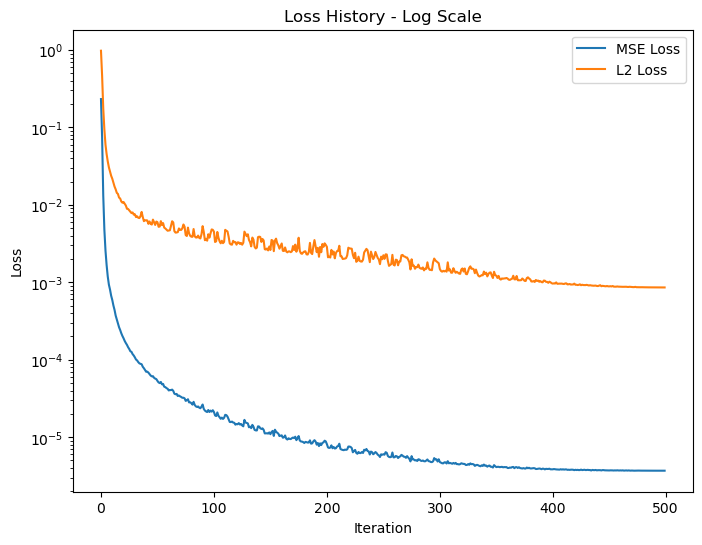

In [49]:
# Plot visualization
plt.figure(figsize=(8, 6))
plt.plot(mse_loss,label="MSE Loss")
plt.plot(l2_loss,label = "L2 Loss") # Relative L2 loss
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History - Log Scale')
plt.legend()
plt.show()

Now let us calculate error values which is means to judge accuracy of our model

In [7]:
# Load the saved model
model = torch.load('ns_fourier')

# Set the model to evaluation mode
model.eval()

FNO1d(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
train_y = y_train.flatten()
test_y = y_test.flatten()

In [9]:
train_pred = model(x_train)
test_pred = model(x_test)

In [11]:
myloss =  LpLoss() #initialise Lploss class object to calculate 'L2-norm'
train_err = myloss(y_train,train_pred).item()/1000
test_err = myloss(y_test,test_pred).item()/100

In [12]:
train_err,test_err

(0.0008567615151405335, 0.0009629473090171814)

In [14]:
print("Relative L2 Loss for Training data is: ",train_err , "\nRelative L2 Loss for Testing data is:  ",test_err)

Relative L2 Loss for Training data is:  0.0008567615151405335 
Relative L2 Loss for Testing data is:   0.0009629473090171814


In [16]:
# Calculate mean squared error
mse_train = torch.mean((train_pred.flatten() - train_y)**2).item()
mse_test = torch.mean((test_pred.flatten() - test_y)**2).item()
print("MSE Loss for Training data is: ",mse_train , "\nMSE Loss for Testing data ",mse_test)
# Calculate root mean squared error
rmse_train = np.sqrt(mse_train)
rmse_test= np.sqrt(mse_test)
print("RMSE Error for Training data is: ",rmse_train , "\nRMSE Error for Testing data ",rmse_test)

MSE Loss for Training data is:  3.688497599796392e-06 
MSE Loss for Testing data  2.04770526579523e-06
RMSE Error for Training data is:  0.001920546172263607 
RMSE Error for Testing data  0.0014309805260013953


Training data plots are like:


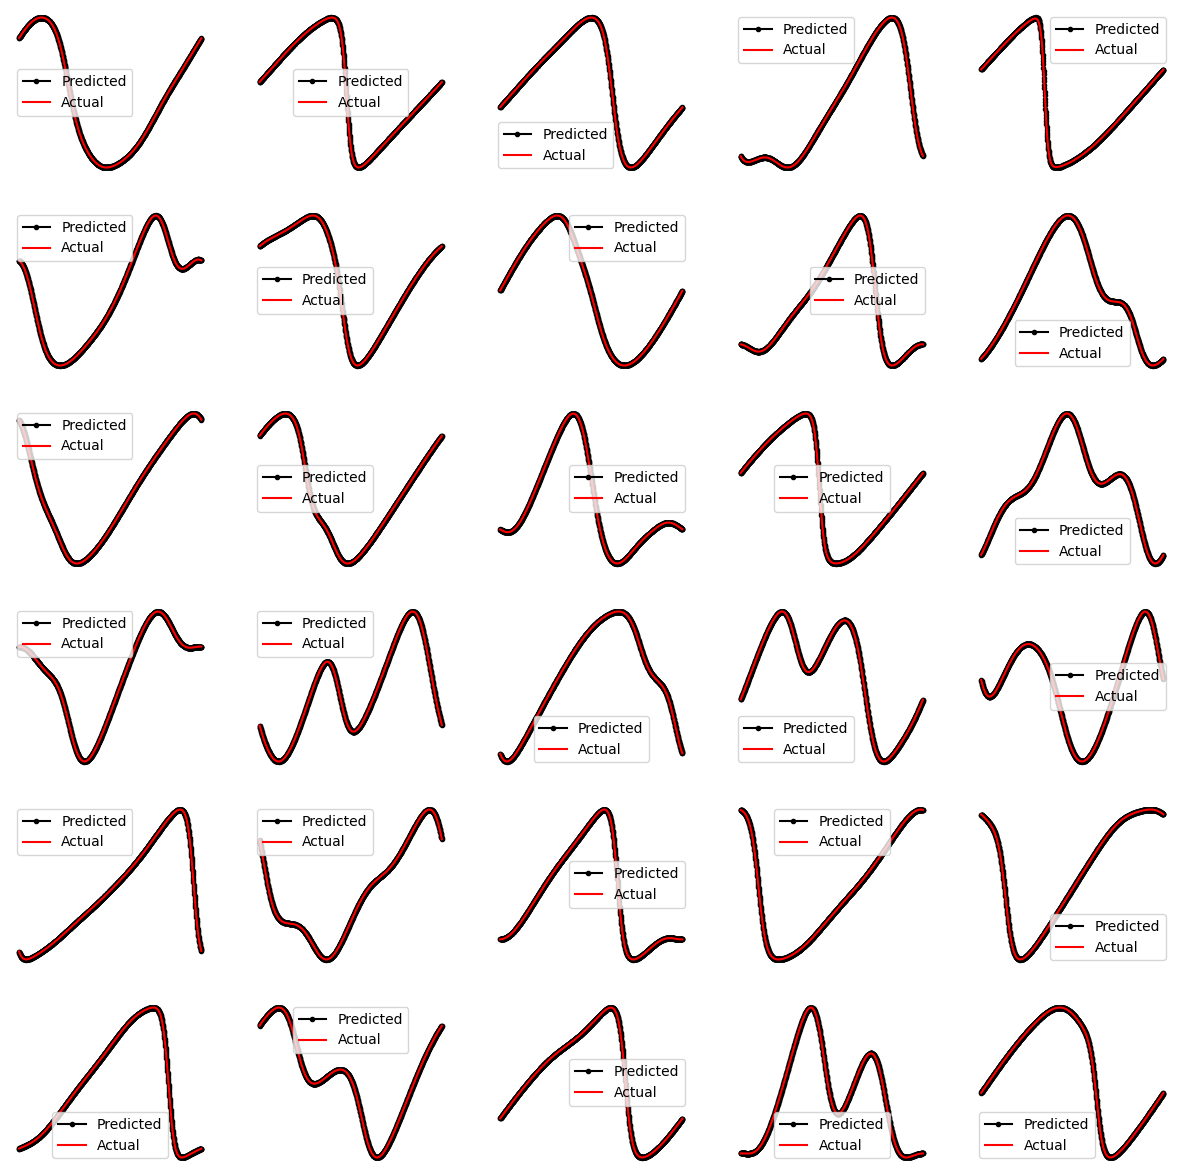

In [17]:
fig = plt.figure(figsize=(15,15))
print("Training data plots are like:")
for i in range(30):  
    r = np.random.choice(x_train.shape[0])
    ax = fig.add_subplot(6, 5, i+1)
    ax.plot(train_pred.detach().numpy()[r],c = 'black', marker='.',label="Predicted")  
    ax.plot(y_train.detach().numpy()[r], c='r',label="Actual")
    plt.legend()
    plt.axis('off')

Testing data plots are like:


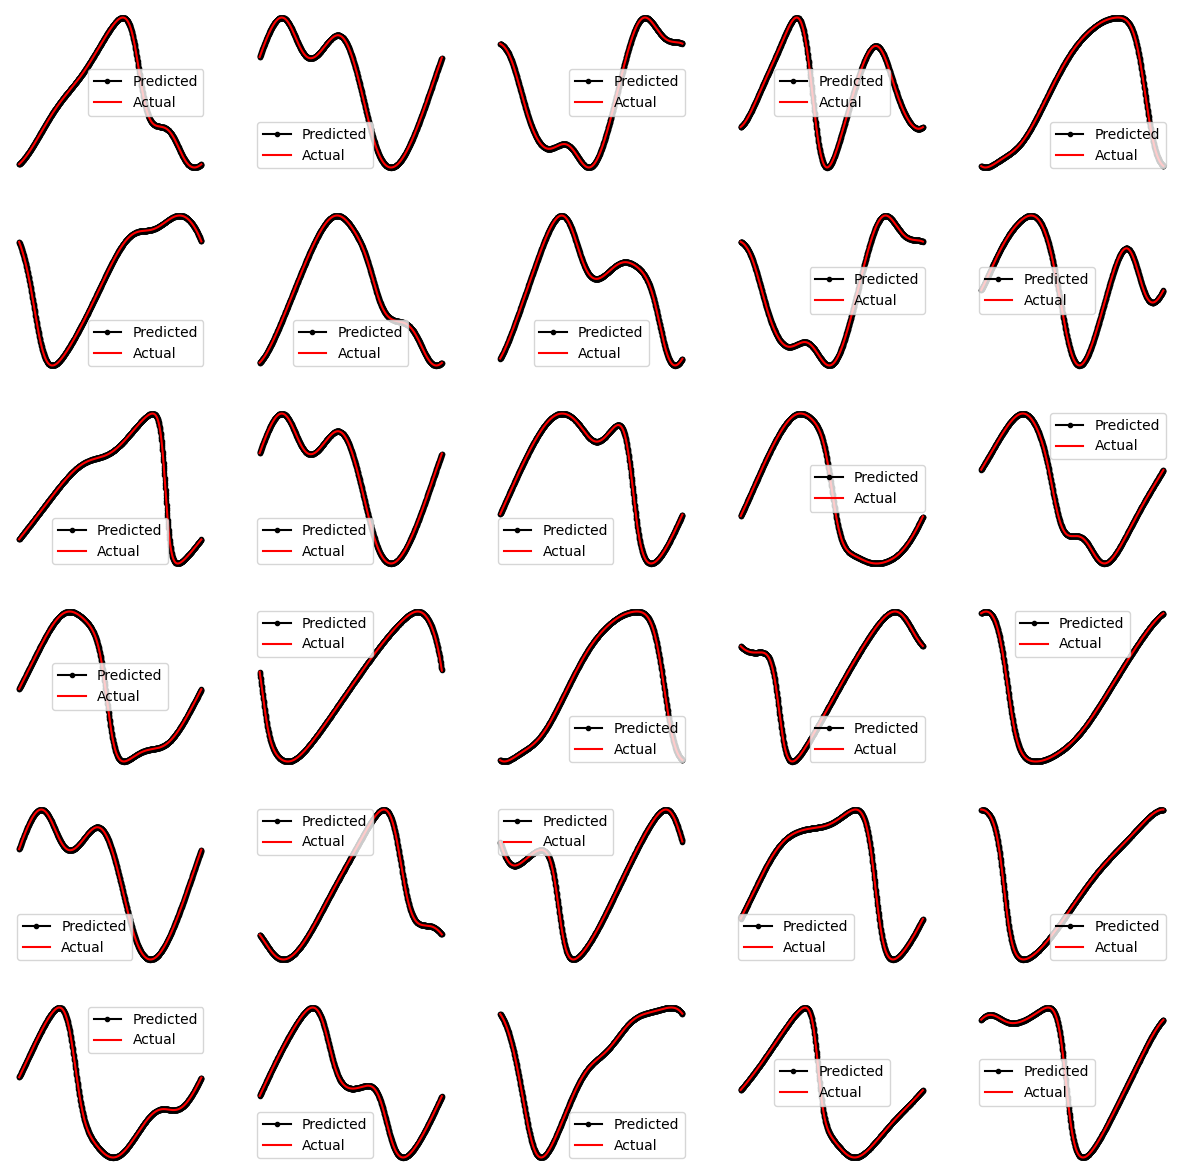

In [18]:
fig = plt.figure(figsize=(15,15))
print("Testing data plots are like:")
for i in range(30):  
    r = np.random.choice(x_test.shape[0])
    ax = fig.add_subplot(6, 5, i+1)
    ax.plot(test_pred.detach().numpy()[r],c = 'black', marker='.',label="Predicted")  
    ax.plot(y_test.detach().numpy()[r], c='r',label="Actual")
    plt.legend()
    plt.axis('off')